In [ ]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
import torch
import torch.optim as optim
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
test_set = torchvision.datasets.FashionMNIST(
    "./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()])
)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

In [ ]:
class FashionCNN:

    def __init__(self):
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(12544, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
        ).to(device)
        self.loss_tab = []
        self.epoch_tab = []

    def forward(self, x):
        return self.model(x)

    def validate(self, test_dataloader, device):
        self.model.eval()  # VALIDACJA
        total = 0
        correct = 0

        with torch.no_grad():  # bez gradientow
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)  # klasa z max prawd

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"accuracy: {accuracy:.2f}%")

    def train_model(self, train_loader, test_loader, num_epochs=10, learning_rate=0.001):

        # optymalizator i funkcja straty
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            self.model.train()
            losss = 0.0

            for inputs, labels in tqdm(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = criterion(outputs, labels)

                # propagacja wsteczna
                loss.backward()
                optimizer.step()

                losss += loss.item()

            self.validate(test_loader, device)
            self.loss_tab.append(losss / len(train_loader))
            self.epoch_tab.append(epoch)
            print(f"Epoch [{epoch}/{num_epochs-1}], Loss: {losss / len(train_loader):.4f}")

In [ ]:
print(FashionCNN().model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=12544, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=64, bias=True)
)


In [ ]:
model = FashionCNN()
model.train_model(train_loader, test_loader)

100%|██████████| 600/600 [00:13<00:00, 45.43it/s]


accuracy: 87.74%
Epoch [0/9], Loss: 0.4366


100%|██████████| 600/600 [00:13<00:00, 43.02it/s]


accuracy: 89.87%
Epoch [1/9], Loss: 0.2509


100%|██████████| 600/600 [00:11<00:00, 52.07it/s]


accuracy: 90.59%
Epoch [2/9], Loss: 0.1930


100%|██████████| 600/600 [00:11<00:00, 50.64it/s]


accuracy: 90.91%
Epoch [3/9], Loss: 0.1503


100%|██████████| 600/600 [00:11<00:00, 51.91it/s]


accuracy: 90.77%
Epoch [4/9], Loss: 0.1124


100%|██████████| 600/600 [00:11<00:00, 52.38it/s]


accuracy: 90.18%
Epoch [5/9], Loss: 0.0844


100%|██████████| 600/600 [00:11<00:00, 51.98it/s]


accuracy: 91.76%
Epoch [6/9], Loss: 0.0672


100%|██████████| 600/600 [00:11<00:00, 52.32it/s]


accuracy: 91.80%
Epoch [7/9], Loss: 0.0533


100%|██████████| 600/600 [00:11<00:00, 50.41it/s]


accuracy: 91.57%
Epoch [8/9], Loss: 0.0422


100%|██████████| 600/600 [00:11<00:00, 52.64it/s]


accuracy: 92.19%
Epoch [9/9], Loss: 0.0326


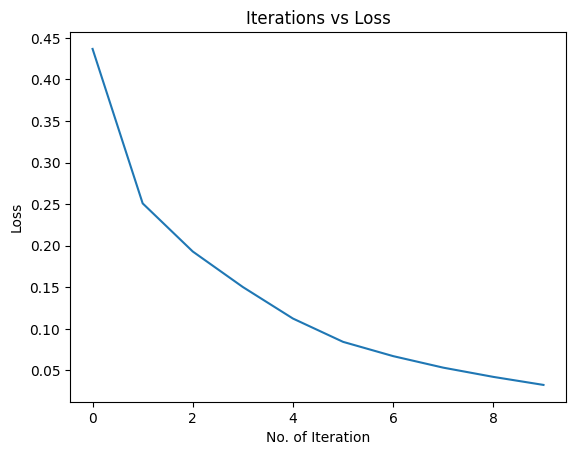

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.epoch_tab, model.loss_tab)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [ ]:
class Autoencoder:
    def __init__(self):
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(12544, 512),
            nn.ReLU(),
            nn.Linear(512, 12),
        ).to(device)

        self.decoder = nn.Sequential(
            nn.Linear(12, 512),
            nn.ReLU(),
            nn.Linear(512, 12544),
            nn.ReLU(),
            nn.Unflatten(1, (64, 14, 14)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        ).to(device)
        self.loss_tab = []
        self.epoch_tab = []

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def validate_model(self, test_dataloader, device):
        self.encoder.eval()
        self.decoder.eval()

        running_loss = 0

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.forward(inputs)
                running_loss += nn.MSELoss()(outputs, inputs).item()

        meanloss = running_loss / len(test_dataloader)
        print(f"Validation Loss: {meanloss:.2f}")

    def train_model(self, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
        optimizer = optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=learning_rate)
        criterion = nn.MSELoss()

        for epoch in range(num_epochs):
            self.encoder.train()
            self.decoder.train()
            losss = 0.0

            for inputs, labels in tqdm(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = self.forward(inputs)
                loss = nn.MSELoss()(outputs, inputs)

                loss.backward()
                optimizer.step()

                losss += loss.item()

            self.validate_model(test_loader, device)
            self.loss_tab.append(losss / len(train_loader))
            self.epoch_tab.append(epoch)

            print(f"Epoch [{epoch}/{num_epochs-1}], Loss: {losss / len(train_loader):.4f}")

In [ ]:
model = Autoencoder()
model.train_model(train_loader, test_loader)

100%|██████████| 600/600 [00:14<00:00, 42.38it/s]


Validation Loss: 0.01
Epoch [0/9], Loss: 0.0222


100%|██████████| 600/600 [00:16<00:00, 36.71it/s]


Validation Loss: 0.01
Epoch [1/9], Loss: 0.0126


100%|██████████| 600/600 [00:14<00:00, 42.19it/s]


Validation Loss: 0.01
Epoch [2/9], Loss: 0.0115


100%|██████████| 600/600 [00:13<00:00, 43.05it/s]


Validation Loss: 0.01
Epoch [3/9], Loss: 0.0109


100%|██████████| 600/600 [00:13<00:00, 42.90it/s]


Validation Loss: 0.01
Epoch [4/9], Loss: 0.0105


100%|██████████| 600/600 [00:14<00:00, 41.77it/s]


Validation Loss: 0.01
Epoch [5/9], Loss: 0.0102


100%|██████████| 600/600 [00:13<00:00, 42.97it/s]


Validation Loss: 0.01
Epoch [6/9], Loss: 0.0100


100%|██████████| 600/600 [00:14<00:00, 40.17it/s]


Validation Loss: 0.01
Epoch [7/9], Loss: 0.0098


100%|██████████| 600/600 [00:13<00:00, 43.17it/s]


Validation Loss: 0.01
Epoch [8/9], Loss: 0.0096


100%|██████████| 600/600 [00:13<00:00, 42.94it/s]


Validation Loss: 0.01
Epoch [9/9], Loss: 0.0094


In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.epoch_tab, model.loss_tab)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()